In [162]:
import numpy as np
from concreteproperties.material import Concrete, Steel
import concreteproperties.stress_strain_profile as ssp
from shapely.geometry import Polygon
from sectionproperties.pre.geometry import Geometry
import sectionproperties.pre.library.primitive_sections as sp_ps
from concreteproperties.pre import add_bar_rectangular_array
from concreteproperties.concrete_section import ConcreteSection

In [163]:
concrete = Concrete(
    name="40 MPa Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.EurocodeNonLinear(
        elastic_modulus=32.8e3,
        ultimate_strain=0.0035,
        compressive_strength=40,
        compressive_strain=0.0023,
        tensile_strength=3.8,
        tension_softening_stiffness=10e3,
    ),
    ultimate_stress_strain_profile=ssp.RectangularStressBlock(
        compressive_strength=40,
        alpha=0.79,
        gamma=0.87,
        ultimate_strain=0.003,
    ),
    alpha_squash=0.85,
    flexural_tensile_strength=3.8,
    colour="lightgrey",
)

steel = Steel(
    name="500 MPa Steel",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelElasticPlastic(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="grey",
)

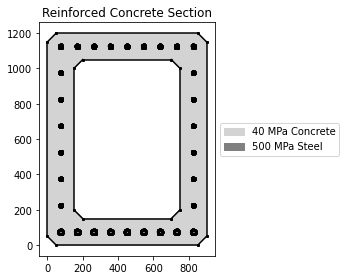

<AxesSubplot:title={'center':'Reinforced Concrete Section'}>

In [164]:
# construct box by subtracting an inner rectangle from an outer rectangle
outer_points = [
    [50, 0],
    [850, 0],
    [900, 50],
    [900, 1150],
    [850, 1200],
    [50, 1200],
    [0, 1150],
    [0, 50]
]
inner_points = [
    [50, 0],
    [550, 0],
    [600, 50],
    [600, 850],
    [550, 900],
    [50, 900],
    [0, 850],
    [0, 50]
]
outer = Geometry(geom=Polygon(outer_points), material=concrete)
inner = Geometry(geom=Polygon(inner_points)).align_center(align_to=outer)
geom = outer - inner

# add bottom bars
geom = add_bar_rectangular_array(
    geometry=geom,
    area=620,
    material=steel,
    n_x=9,
    x_s=750 / 8,
    anchor=(75, 75),
    n=16,
)

# add top bars
geom = add_bar_rectangular_array(
    geometry=geom,
    area=310,
    material=steel,
    n_x=9,
    x_s=750 / 8,
    anchor=(75, 1125),
    n=16,
)

# add side bars
geom = add_bar_rectangular_array(
    geometry=geom,
    area=200,
    material=steel,
    n_x=2,
    x_s=750,
    n_y=6,
    y_s=150,
    anchor=(75, 225),
    n=16,
)

conc_sec = ConcreteSection(geom)
conc_sec.plot_section()

In [165]:
mk_res = conc_sec.moment_curvature_analysis()

Output()

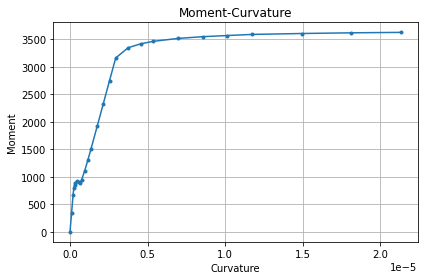

<AxesSubplot:title={'center':'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [166]:
mk_res.plot_results()

In [167]:
kappa_list = np.arange(0, 2e-5, 5e-8)
n_kappa = len(kappa_list)
print(n_kappa)

401


In [168]:
stress_res_list = []
moment_list = [0]

for idx, kappa in enumerate(kappa_list[1:]):
    stress_res = conc_sec.calculate_service_stress(
        moment_curvature_results=mk_res, m=None, kappa=kappa
    )
    stress_res_list.append(stress_res)
    moment_list.append(stress_res.sum_moments())
    if idx % 20 == 0:
        print(f"{idx/(n_kappa-1)*100:.2f}% complete")

0.00% complete
5.00% complete
10.00% complete
15.00% complete
20.00% complete
25.00% complete
30.00% complete
35.00% complete
40.00% complete
45.00% complete
50.00% complete
55.00% complete
60.00% complete
65.00% complete
70.00% complete
75.00% complete
80.00% complete
85.00% complete
90.00% complete
95.00% complete


In [169]:
# modified plot stress function
from concreteproperties.post import plotting_context
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from matplotlib.colors import CenteredNorm
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import warnings

def plot_stress_and_graph(res_idx, mk_res_list, k_list, m_list, **kwargs):
    with plotting_context(title="Stress", **kwargs) as (fig, ax):
        # plot background
        mk_res_list[res_idx].concrete_section.plot_section(background=True, **dict(kwargs, ax=ax))
        
        # set up the colormaps
        cmap_conc = cm.get_cmap(name="RdGy")
        cmap_steel = cm.get_cmap(name="bwr")

        # determine minimum and maximum stress values for the contour list
        # add tolerance for plotting stress blocks
        conc_sig_min = min([min(x) for x in mk_res_list[res_idx].concrete_stresses]) - 1e-12
        conc_sig_max = max([max(x) for x in mk_res_list[res_idx].concrete_stresses]) + 1e-12
        steel_sig_min = min(mk_res_list[res_idx].steel_stresses)
        steel_sig_max = max(mk_res_list[res_idx].steel_stresses)

        # set up ticks
        v_conc = np.linspace(conc_sig_min, conc_sig_max, 15, endpoint=True)
        v_steel = np.linspace(steel_sig_min, steel_sig_max, 15, endpoint=True)
        ticks_conc = v_conc
        ticks_steel = v_steel
        
        # plot the concrete stresses
        for idx, sig in enumerate(mk_res_list[res_idx].concrete_stresses):
            # check region has a force
            if abs(mk_res_list[res_idx].concrete_forces[idx][0]) > 1e-8:
                # create triangulation
                triang = tri.Triangulation(
                    mk_res_list[res_idx].concrete_analysis_sections[idx].mesh_nodes[:, 0],
                    mk_res_list[res_idx].concrete_analysis_sections[idx].mesh_nodes[:, 1],
                    mk_res_list[res_idx].concrete_analysis_sections[idx].mesh_elements[:, 0:3],
                )
                
                # plot the filled contour
                trictr = ax.tricontourf(
                    triang, sig, v_conc, cmap=cmap_conc, norm=CenteredNorm()
                )

                # plot a zero stress contour, supressing warning
                with warnings.catch_warnings():
                    warnings.filterwarnings(
                        "ignore",
                        message="No contour levels were found within the data range.",
                    )

                    # set zero stress for neutral axis contour
                    zero_level = 0

                    if min(sig) > 0:
                        if min(sig) < 1e-3:
                            zero_level = min(sig) + 1e-12

                    if max(sig) < 0:
                        if max(sig) > -1e-3:
                            zero_level = max(sig) - 1e-12

                    if min(sig) == 0:
                        zero_level = 1e-12

                    if max(sig) == 0:
                        zero_level = -1e-12

                    CS = ax.tricontour(
                        triang, sig, [zero_level], linewidths=1, linestyles="dashed"
                    )
                    
        # plot the steel stresses
        steel_patches = []
        colours = []

        for idx, sig in enumerate(mk_res_list[res_idx].steel_stresses):
            steel_patches.append(
                mpatches.Polygon(
                    xy=list(
                        mk_res_list[res_idx].concrete_section.steel_geometries[
                            idx
                        ].geom.exterior.coords
                    )
                )
            )
            colours.append(sig)

        patch = PatchCollection(steel_patches, cmap=cmap_steel)
        patch.set_array(colours)
        ax.add_collection(patch)
        ax.set_aspect("equal", anchor="C")
        ax.set_xlim(0,900)
        ax.set_ylim(0,1200)
        
        fig = ax.get_figure()
        fig.axes[1].plot(k_list[:res_idx+2], np.array(m_list[:res_idx+2])/1e6)
        plt.xlabel("Curvature")
        plt.ylabel("Moment")
        plt.title("Moment-Curvature")
        fig.axes[1].set_xlim(0,2.5e-5)
        fig.axes[1].set_ylim(0,3700)
        plt.grid(True)

    return ax

In [170]:
# generate images
for i in range(len(stress_res_list)):
    ax = plot_stress_and_graph(
        i, stress_res_list, kappa_list, moment_list, ncols=2, filename=f"anim/{i:03d}.png", dpi=200
    )